# Implementation of k-means Clustering Algorithm

## Introduction

The aim of this project is to prepare, implement, and verify experimentally the k-means algorithm for partitioning data.

### Key Steps in Implementing the Algorithm

1. **Translation of the Algorithm into Code**: Breaking down its steps into functions, loops, conditionals, and other structures. This involves:
    1. **Initialization**
    2. **Assignment**
    3. **Update**
    4. **Convergence Check**: 

2. **Improvement to k-means++**: Enhancing the algorithm to k-means++ and observing its performance.

3. **Testing and Debugging**: Evaluating the algorithm using existing libraries and comparing its performance to the custom implementation.

### Papers and References

This implementation references the following key papers and books:

- **"The k-means clustering technique: General considerations and implementation in Mathematica"**: This paper provides a detailed explanation of the k-means algorithm, including its theoretical design and practical implementation. It serves as the primary guide for understanding and implementing the k-means algorithm in this project.
  
- **"k-means++: The Advantages of Careful Seeding" by David Arthur and Sergei Vassilvitskii**: This paper introduces k-means++, an improved version of k-means, which provides a better initialization method for centroids, improving the overall performance of the algorithm.
  
- **"Data Mining: Concepts and Techniques (3rd ed.)" by Jiawei Han, Micheline Kamber, and Jian Pei**: This book is a comprehensive resource on data mining techniques, including clustering algorithms such as k-means. It provides foundational knowledge and theoretical insights that support the implementation of the k-means algorithm.

### Dataset

#### Description

The dataset used in this notebook is a synthetic dataset from the clustering benchmark repository. It contains 5000 data points with two features (x and y), and it is divided into 5 clusters.

- **Source**: Clustering Benchmark Datasets [GitHub Repository](https://github.com/deric/clustering-benchmark)
- **File**: `s-set1.arff`
- **Format**: ARFF (Attribute-Relation File Format)

#### Features

- **x**: The first feature of the data point, representing a coordinate on the x-axis.
- **y**: The second feature of the data point, representing a coordinate on the y-axis.
- **CLASS**: The class label for the data point, indicating the cluster to which the point belongs (not used in clustering but for validation).


## Necessary Libraries

In [5]:
import urllib.request
import pandas as pd
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

## Load and Prepare the Dataset

In [6]:
#  Download file
url = "https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/artificial/s-set1.arff"
local_file = "s-set1.arff"
urllib.request.urlretrieve(url, local_file)

# Step 2: Load the ARFF file
data, meta = arff.loadarff(local_file)
df = pd.DataFrame(data)

# Display the first few rows of the dataset
print(df.head())

# Display basic statistics
print(df.describe())

print("\nBasic information about the dataset:")
print(df.info())


          x         y  CLASS
0  664159.0  550946.0  b'14'
1  665845.0  557965.0  b'14'
2  597173.0  575538.0  b'14'
3  618600.0  551446.0  b'14'
4  635690.0  608046.0  b'14'
                   x              y
count    5000.000000    5000.000000
mean   514937.556600  494709.292800
std    244465.901926  235840.852969
min     19835.000000   51121.000000
25%    320352.500000  320107.750000
50%    505338.500000  526259.500000
75%    786228.750000  713713.500000
max    961951.000000  970756.000000

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       5000 non-null   float64
 1   y       5000 non-null   float64
 2   CLASS   5000 non-null   object 
dtypes: float64(2), object(1)
memory usage: 117.3+ KB
None


In [3]:
data, meta = arff.loadarff(local_file)
df = pd.DataFrame(data)

# Convert byte strings to normal strings if necessary
df['CLASS'] = df['CLASS'].str.decode('utf-8')

# Extract features
X = df[['x', 'y']].values

print("Data loaded successfully!")

Data loaded successfully!


# Initialize Centroids

We will set the number of clusters to 5 because the dataset is known to have 5 clusters based on its description.


In [8]:
import random

def initialize_centroids(X, k):
    """Randomly select k points from the dataset as initial centroids."""
    centroids = random.sample(X, k)
    return centroids

# Convert the dataset to a list of lists
X = df[['x', 'y']].values.tolist()

# Number of clusters
k = 5

# Initialize centroids
centroids = initialize_centroids(X, k)
print("Initial centroids:\n", centroids)


Initial centroids:
 [[229280.0, 813483.0], [125902.0, 318850.0], [575022.0, 213534.0], [334350.0, 556417.0], [813092.0, 739043.0]]


# Assign Clusters


In [9]:
def assign_clusters(X, centroids):
    """Assign each data point to the nearest centroid."""
    clusters = []
    for point in X:
        distances = [((point[0] - centroid[0]) ** 2 + (point[1] - centroid[1]) ** 2) ** 0.5 for centroid in centroids]
        cluster = distances.index(min(distances))
        clusters.append(cluster)
    return clusters

# Assign clusters
clusters = assign_clusters(X, centroids)
print("First 10 cluster assignments:\n", clusters[:10])


First 10 cluster assignments:
 [4, 4, 3, 4, 4, 3, 3, 4, 3, 4]


# Update Centroids


In [10]:
def update_centroids(X, clusters, k):
    """Calculate new centroids as the mean of all points assigned to each centroid."""
    new_centroids = []
    for i in range(k):
        cluster_points = [X[j] for j in range(len(X)) if clusters[j] == i]
        if cluster_points:
            new_centroid = [sum(coord) / len(cluster_points) for coord in zip(*cluster_points)]
            new_centroids.append(new_centroid)
        else:
            new_centroids.append([0, 0])  # handle empty clusters
    return new_centroids

# Update centroids
new_centroids = update_centroids(X, clusters, k)
print("Updated centroids:\n", new_centroids)


Updated centroids:
 [[321320.7688751926, 817555.8043143298], [207255.77586206896, 299535.9982758621], [655362.5469277515, 252615.47738014854], [335074.6547945205, 516584.80639269407], [760203.8284518828, 694090.3623430963]]


# Check Convergence


In [12]:
def has_converged(old_centroids, new_centroids, tol=1e-4):
    """Check if the centroids have converged."""
    distances = [((old_centroid[0] - new_centroid[0]) ** 2 + (old_centroid[1] - new_centroid[1]) ** 2) ** 0.5
                 for old_centroid, new_centroid in zip(old_centroids, new_centroids)]
    return all(distance < tol for distance in distances)

# Example usage:
old_centroids = centroids
centroids = new_centroids
converged = has_converged(old_centroids, centroids)
print("Has converged:", converged)


Has converged: False


In [13]:
def kmeans(X, k, max_iter=100, tol=1e-4):
    """Full k-means algorithm."""
    # Initialize centroids
    centroids = initialize_centroids(X, k)
    
    for _ in range(max_iter):
        # Assign clusters
        clusters = assign_clusters(X, centroids)
        
        # Update centroids
        new_centroids = update_centroids(X, clusters, k)
        
        # Check for convergence
        if has_converged(centroids, new_centroids, tol):
            break
        
        centroids = new_centroids
    
    return clusters, centroids

# Example usage
k = 5
clusters, centroids = kmeans(X, k)
print("Final centroids:\n", centroids)


Final centroids:
 [[259047.7289021658, 469522.58028379385], [329618.53403933434, 818757.641452345], [416482.98044692737, 175519.96787709498], [758509.3695871098, 296336.2658610272], [742481.3361735089, 684525.7312161116]]


# Visualize Clustering Results


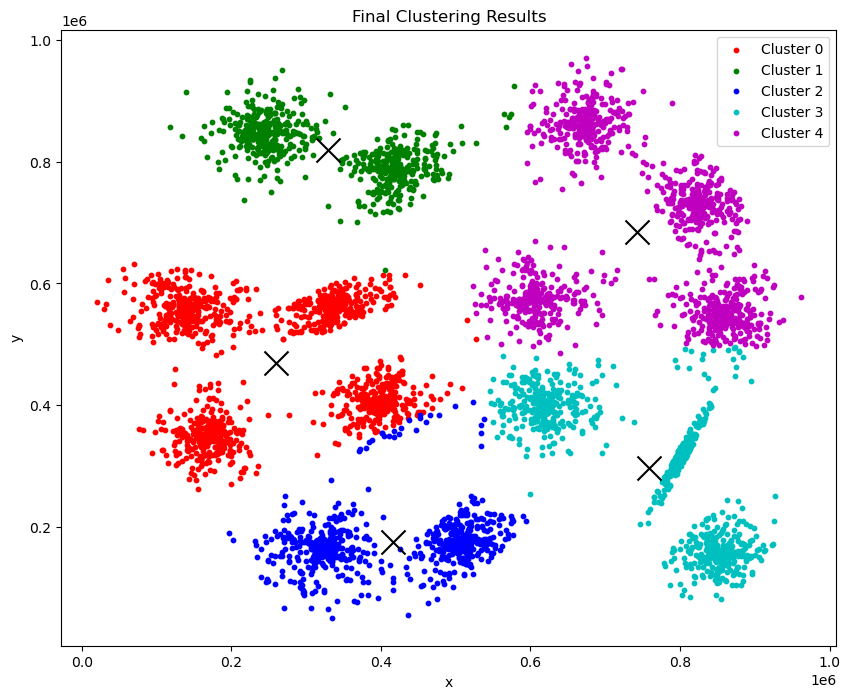

In [14]:
import matplotlib.pyplot as plt

def plot_clusters(X, centroids, clusters, title="Clustering Results"):
    """Plot the data points and centroids."""
    plt.figure(figsize=(10, 8))
    
    # Create a color map
    colors = ['r', 'g', 'b', 'c', 'm']
    
    for i in range(len(centroids)):
        # Plot points in cluster
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        points = np.array(points)
        plt.scatter(points[:, 0], points[:, 1], s=10, color=colors[i], label=f'Cluster {i}')
        
        # Plot centroids
        plt.scatter(centroids[i][0], centroids[i][1], s=300, c='k', marker='x')
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Visualize the final clustering
plot_clusters(X, centroids, clusters, title="Final Clustering Results")


# Calculate Silhouette Score


Silhouette Score: 0.46392568634109593


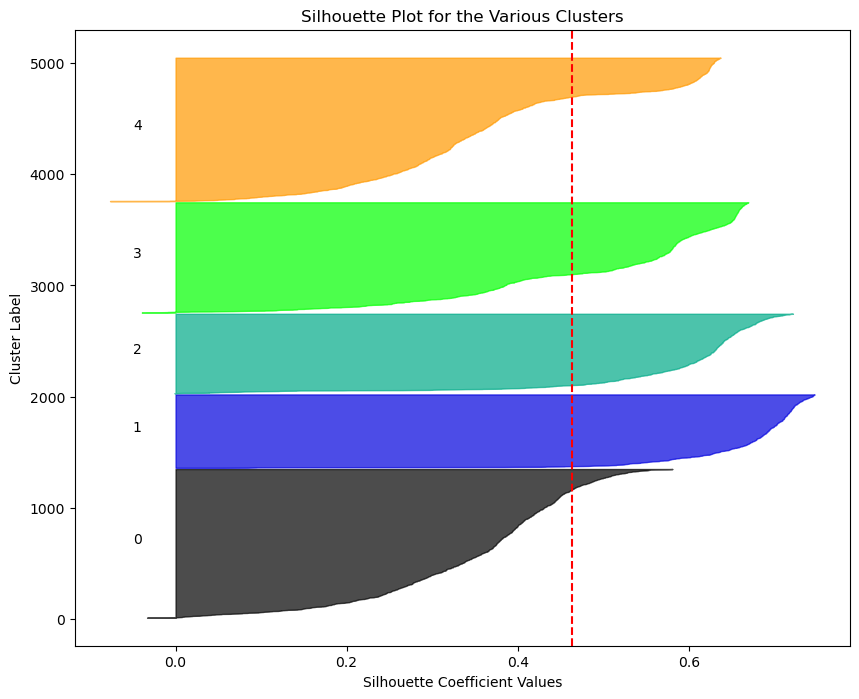

In [15]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# Convert clusters list to numpy array for compatibility with sklearn
clusters_np = np.array(clusters)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, clusters_np)
print("Silhouette Score:", silhouette_avg)

# Calculate silhouette values for each point
silhouette_values = silhouette_samples(X, clusters_np)

# Visualize the Silhouette Score
def plot_silhouette(X, clusters, silhouette_values):
    """Plot the silhouette score for each sample."""
    y_lower = 10
    k = len(np.unique(clusters))
    plt.figure(figsize=(10, 8))
    
    for i in range(k):
        ith_cluster_silhouette_values = silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Label")
    plt.title("Silhouette Plot for the Various Clusters")
    plt.show()

# Plot silhouette
plot_silhouette(X, clusters_np, silhouette_values)


### Observations

#### Silhouette Score
- **Silhouette Score**: The average silhouette score is 0.4639. A score closer to 1 indicates that the points are well-clustered, while a score closer to -1 indicates that the points are poorly clustered.
  
#### Silhouette Plot
- **Cluster Quality**: The silhouette plot provides a visual representation of how well each data point lies within its cluster. 
  - **Cluster 0 (Black)**: This cluster shows a wide range of silhouette coefficients, indicating some points are well-clustered while others are not as well-clustered.
  - **Cluster 1 (Blue)**: This cluster also shows variation, but most points have a silhouette coefficient close to the average score.
  - **Cluster 2 (Teal)**: This cluster has a narrow range of silhouette coefficients, indicating more consistent clustering.
  - **Cluster 3 (Green)**: Similar to Cluster 2, this cluster also shows a narrow range of silhouette coefficients.
  - **Cluster 4 (Orange)**: This cluster has the highest silhouette coefficients, indicating very well-clustered points.

### Calculate Inertia for Current Clustering

We will calculate the inertia (within-cluster sum of squares) for the current clustering to measure the compactness of the clusters.


In [22]:
import numpy as np

# Ensure X is a numpy array
X = np.array(X)

def calculate_inertia(X, clusters, centroids):
    inertia = 0
    clusters = np.array(clusters, dtype=int)  # Ensure clusters is a numpy array of integers
    centroids = np.array(centroids)  # Ensure centroids is a numpy array
    for i in range(len(centroids)):
        points = X[clusters == i]
        centroid = centroids[i]
        inertia += np.sum((points - centroid) ** 2)
    return inertia

inertia = calculate_inertia(X, np.array(clusters), centroids)
print("Inertia:", inertia)


Inertia: 104935513328366.2


### Elbow Method to Determine Optimal Number of Clusters


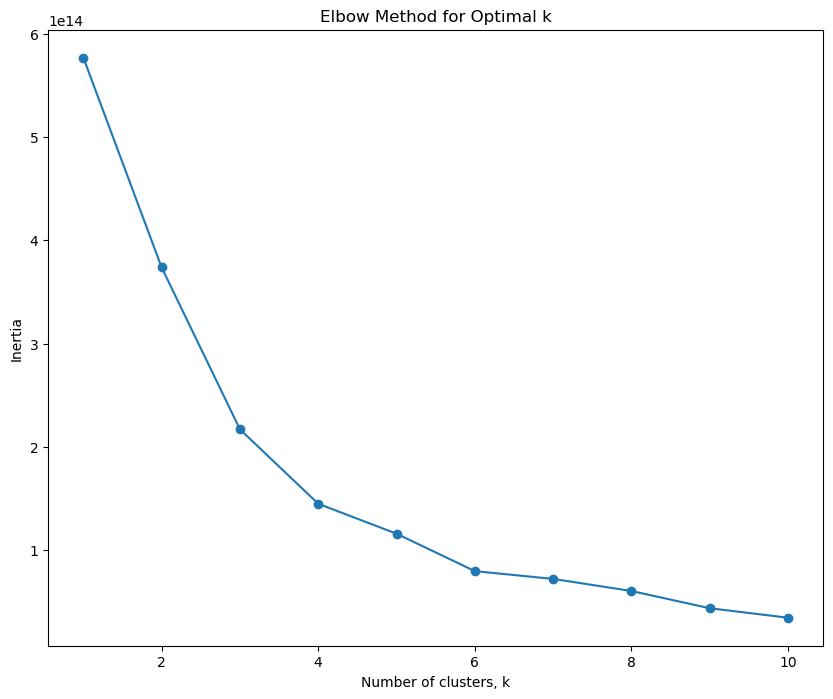

In [23]:
def calculate_inertia_for_k(X, max_k):
    inertias = []
    for k in range(1, max_k + 1):
        # Initialize centroids
        centroids = initialize_centroids(X.tolist(), k)
        clusters = assign_clusters(X.tolist(), centroids)
        for _ in range(max_iters):
            new_centroids = update_centroids(X.tolist(), clusters, k)
            clusters = assign_clusters(X.tolist(), new_centroids)
            if np.allclose(centroids, new_centroids):
                break
            centroids = new_centroids
        inertia = calculate_inertia(X, clusters, centroids)
        inertias.append(inertia)
    return inertias

# Calculate inertia for k values from 1 to 10
max_k = 10
max_iters = 100
inertias = calculate_inertia_for_k(X, max_k)

# Plot the Elbow Plot
plt.figure(figsize=(10, 8))
plt.plot(range(1, max_k + 1), inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.show()


### Observations on the Elbow Curve

The Elbow Curve shows:

1. **Steep Decrease**: A significant drop in inertia from 1 to 2 clusters, indicating a major reduction in within-cluster variance.
2. **Gradual Decrease**: A slower decline from 2 to 5 clusters, suggesting diminishing returns with each additional cluster.
3. **Elbow Point**: The curve forms an "elbow" around 5 clusters, indicating this as the optimal number of clusters where adding more clusters results in minimal reduction in inertia.


### Davies-Bouldin Index Calculation

In [25]:
import numpy as np

def calculate_davies_bouldin_index(X, clusters, centroids):
    n_clusters = len(centroids)
    centroids = np.array(centroids)  # Convert centroids to numpy array
    cluster_k = [np.array([X[i] for i in range(len(X)) if clusters[i] == k]) for k in range(n_clusters)]
    s = [np.mean(np.linalg.norm(cluster_k[i] - centroids[i], axis=1)) for i in range(n_clusters)]
    db_index = 0.0

    for i in range(n_clusters):
        max_r = float('-inf')
        for j in range(n_clusters):
            if i != j:
                m_ij = np.linalg.norm(centroids[i] - centroids[j])
                r_ij = (s[i] + s[j]) / m_ij
                max_r = max(max_r, r_ij)
        db_index += max_r

    db_index /= n_clusters
    return db_index

davies_bouldin = calculate_davies_bouldin_index(X, clusters, centroids)
print("Davies-Bouldin Index:", davies_bouldin)


Davies-Bouldin Index: 0.7444355837187293


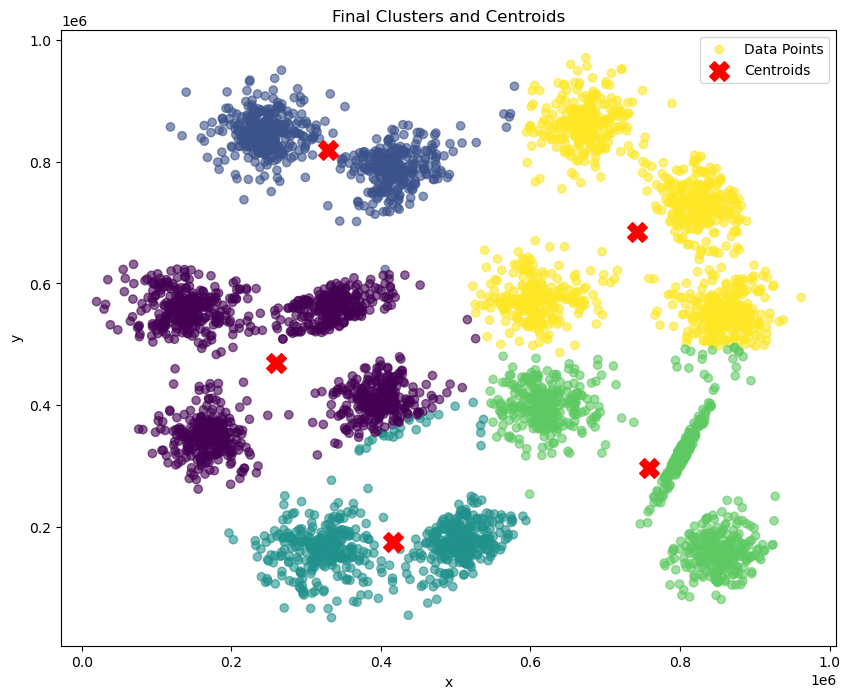

In [26]:
# Function to visualize clusters and centroids
def plot_clusters(X, clusters, centroids, title):
    plt.figure(figsize=(10, 8))
    plt.scatter([x[0] for x in X], [x[1] for x in X], c=clusters, cmap='viridis', marker='o', alpha=0.6, label='Data Points')
    plt.scatter([c[0] for c in centroids], [c[1] for c in centroids], c='red', marker='X', s=200, label='Centroids')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Plot the final clusters and centroids
plot_clusters(X, clusters, centroids, "Final Clusters and Centroids")


### Observations on the Final Clusters and Centroids

- The clusters formed are well-separated, indicating that the k-means algorithm successfully partitioned the data into distinct groups.
- Each cluster is represented by a different color, and the centroids are marked with red 'X' symbols.
- The positions of the centroids appear to be central to their respective clusters, which is expected as k-means aims to minimize within-cluster variance.
- Some clusters are more densely packed than others, which suggests varying densities within the data.


## k-means++ Initialization
The following code implements the k-means++ initialization method to choose initial centroids for the k-means clustering algorithm.


In [32]:
import numpy as np
import random

def initialize_centroids(X, k):
    n_samples, n_features = X.shape
    centroids = np.empty((k, n_features))
    first_centroid = X[np.random.choice(n_samples)]
    centroids[0] = first_centroid
    
    for i in range(1, k):
        distances = np.min(np.array([np.linalg.norm(X - centroid, axis=1) for centroid in centroids[:i]]), axis=0)
        probabilities = distances / distances.sum()
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        next_centroid = X[np.where(cumulative_probabilities >= r)[0][0]]
        centroids[i] = next_centroid
        
    return centroids


## Assign Points to the Nearest Centroid
This function assigns each point in the dataset to the nearest centroid based on the Euclidean distance.


In [39]:
def assign_clusters(X, centroids):
    clusters = []
    for x in X:
        distances = [np.linalg.norm(x - c) for c in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)


In [40]:
# Number of clusters
k = 5

# Convert the dataset to a numpy array
X = np.array(df[['x', 'y']])

# Initialize centroids using k-means++
initial_centroids = initialize_centroids(X, k)
print("Initial centroids chosen by k-means++:\n", initial_centroids)

# Assign clusters based on the initial centroids
clusters = assign_clusters(X, initial_centroids)
print("Cluster assignments for the first 10 points:\n", clusters[:10])


Initial centroids chosen by k-means++:
 [[408689. 562521.]
 [397735. 448097.]
 [790149. 565157.]
 [104489. 542515.]
 [644301. 925034.]]
Cluster assignments for the first 10 points:
 [2 2 0 2 2 0 0 2 0 2]


## Visualizations
1. **Data Points**: Plot all data points.
2. **Initial Centroids**: Plot initial centroids obtained from k-means++ initialization.
3. **Cluster Assignments**: Plot data points colored by cluster assignments.
4. **Updated Centroids**: Plot updated centroids after one iteration of k-means.


In [41]:
import matplotlib.pyplot as plt

# Function to plot data points and centroids
def plot_clusters(X, centroids=None, clusters=None, title="Clusters"):
    plt.figure(figsize=(10, 8))
    
    # Plot data points
    if clusters is None:
        plt.scatter(X[:, 0], X[:, 1], s=10, color='blue')
    else:
        for i in range(k):
            points = X[clusters == i]
            plt.scatter(points[:, 0], points[:, 1], s=10, label=f'Cluster {i}')
    
    # Plot centroids
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=200, color='red', marker='X')
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


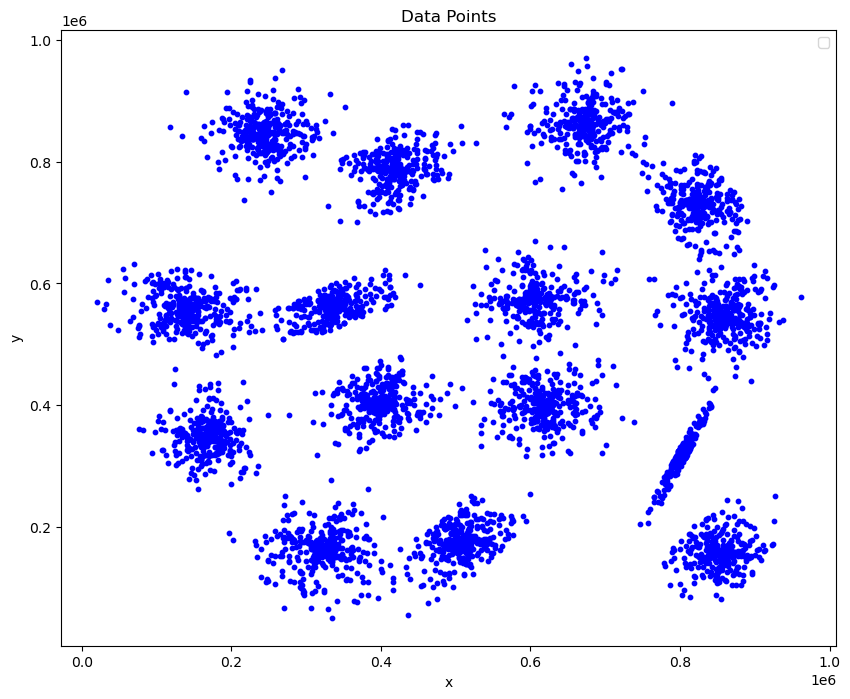

In [42]:
# Plot data points
plot_clusters(X, title="Data Points")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


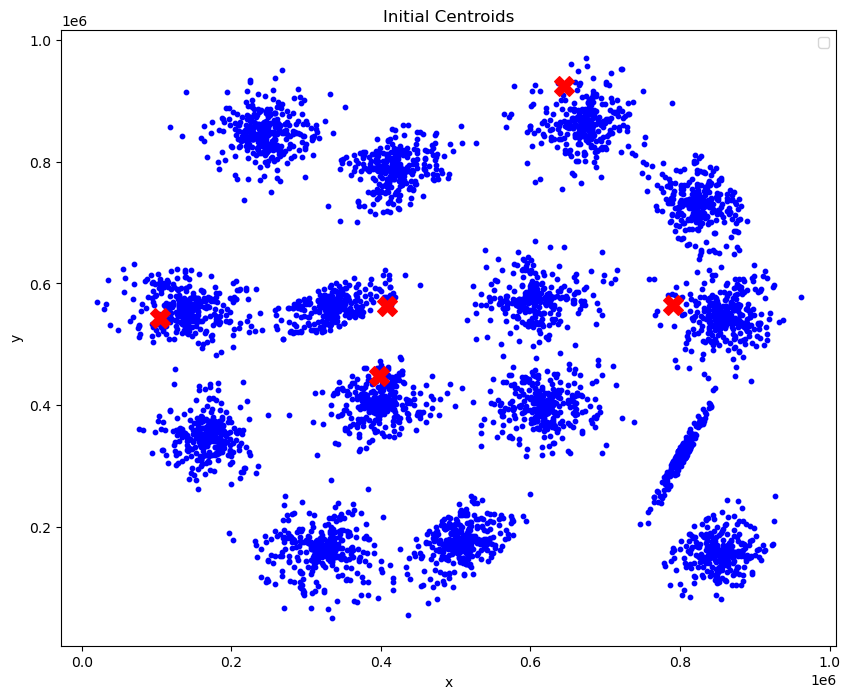

In [43]:
# Plot initial centroids
plot_clusters(X, centroids=initial_centroids, title="Initial Centroids")


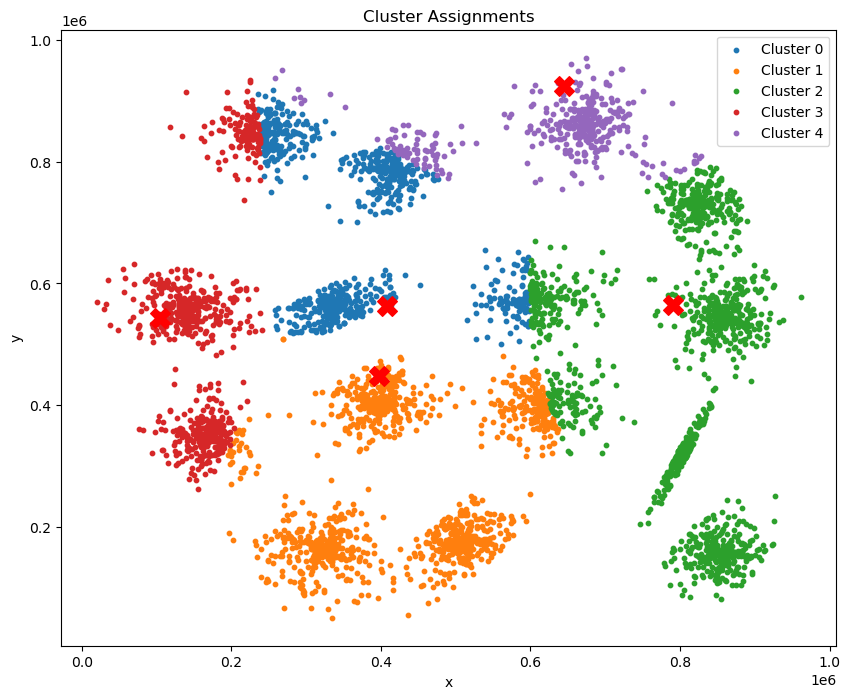

In [44]:
# Plot cluster assignments
plot_clusters(X, centroids=initial_centroids, clusters=clusters, title="Cluster Assignments")


## Update Centroids
This function updates the centroids by computing the mean of all points assigned to each cluster.


In [45]:
def update_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        points_in_cluster = X[clusters == i]
        if len(points_in_cluster) > 0:
            new_centroid = points_in_cluster.mean(axis=0)
        else:
            new_centroid = np.random.rand(1, X.shape[1])
        new_centroids.append(new_centroid)
    return np.array(new_centroids)


## Combined Visualizations
1. **Data Points**: Plot all data points.
2. **Initial Centroids**: Plot initial centroids obtained from k-means++ initialization.
3. **Cluster Assignments**: Plot data points colored by cluster assignments.
4. **Updated Centroids**: Plot updated centroids after one iteration of k-means.


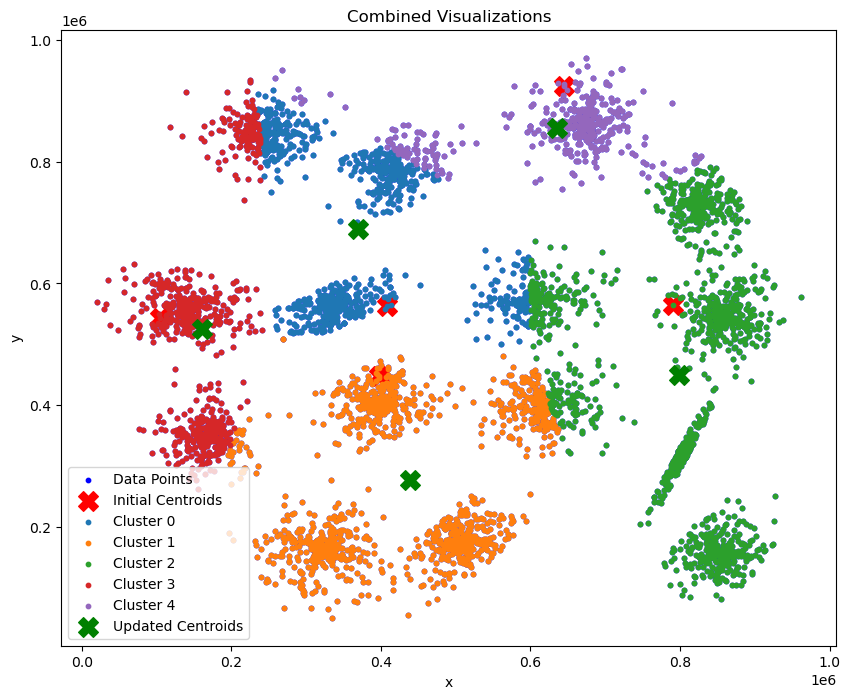

In [46]:
import matplotlib.pyplot as plt

# Function to plot data points and centroids
def plot_clusters_combined(X, initial_centroids, clusters, updated_centroids, title="Clusters"):
    plt.figure(figsize=(10, 8))
    
    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], s=10, color='blue', label='Data Points')
    
    # Plot initial centroids
    plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], s=200, color='red', marker='X', label='Initial Centroids')
    
    # Plot cluster assignments
    for i in range(k):
        points = X[clusters == i]
        plt.scatter(points[:, 0], points[:, 1], s=10, label=f'Cluster {i}')
    
    # Plot updated centroids
    plt.scatter(updated_centroids[:, 0], updated_centroids[:, 1], s=200, color='green', marker='X', label='Updated Centroids')
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Combine the steps and plot
new_centroids = update_centroids(X, clusters, k)
plot_clusters_combined(X, initial_centroids, clusters, new_centroids, title="Combined Visualizations")


## Check for Convergence
This function checks if the centroids have converged by comparing the old and new centroids.


In [47]:
def has_converged(old_centroids, new_centroids, tol=1e-4):
    distances = [np.linalg.norm(oc - nc) for oc, nc in zip(old_centroids, new_centroids)]
    return np.max(distances) < tol


### Test Convergence Check
Test the convergence function with a simple example to ensure it works correctly.


In [48]:
# Define old and new centroids for testing
old_centroids = np.array([[1, 2], [3, 4], [5, 6]])
new_centroids = np.array([[1.0001, 2.0001], [3, 4], [5, 6]])

# Test the convergence function
converged = has_converged(old_centroids, new_centroids)
print("Has converged:", converged)


Has converged: False


## Full k-means++ Algorithm
This code combines all the previous steps into the full k-means++ algorithm.


### Full k-means++ Algorithm
Combine initialization, assignment, update, and convergence check into the full k-means++ algorithm.


In [49]:
def kmeans_plusplus(X, k, max_iter=300, tol=1e-4):
    # Step 1: Initialize centroids using k-means++
    centroids = initialize_centroids(X, k)
    
    for iteration in range(max_iter):
        # Step 2: Assign clusters
        clusters = assign_clusters(X, centroids)
        
        # Step 3: Update centroids
        new_centroids = update_centroids(X, clusters, k)
        
        # Step 4: Check for convergence
        if has_converged(centroids, new_centroids, tol):
            break
        
        centroids = new_centroids
    
    return clusters, centroids

# Example usage:
k = 5  # Number of clusters
clusters, centroids = kmeans_plusplus(X, k)

# Display final centroids
print("centroids:\n", centroids)


centroids:
 [[259047.72890217 469522.58028379]
 [742481.33617351 684525.73121611]
 [416482.98044693 175519.96787709]
 [329618.53403933 818757.64145234]
 [758509.36958711 296336.26586103]]


## Clustering Results
This visualization shows the final clustering results after running the k-means++ algorithm.


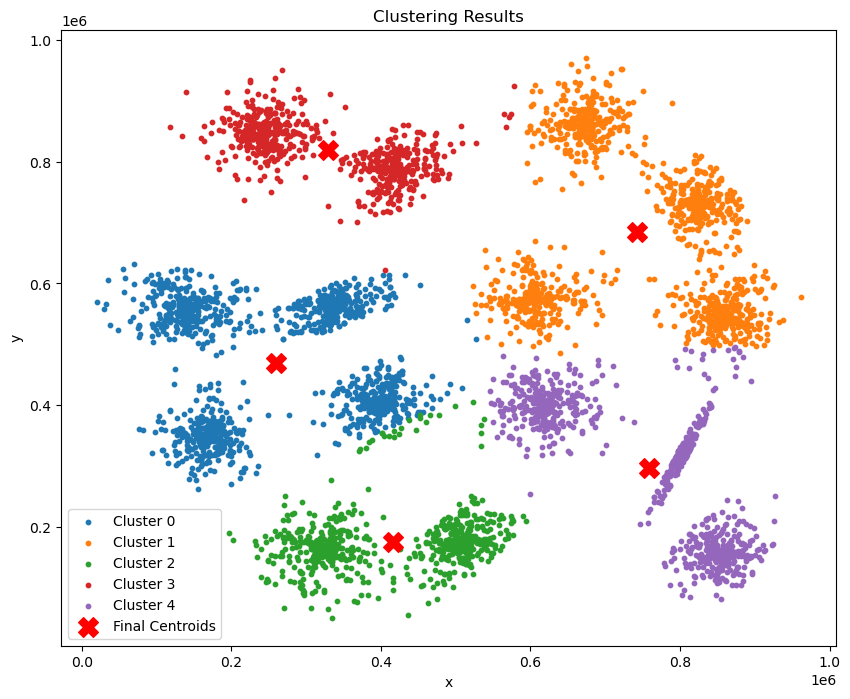

In [50]:
import matplotlib.pyplot as plt

# Function to plot data points and centroids
def plot_final_clusters(X, centroids, clusters, title="Final Clustering Results"):
    plt.figure(figsize=(10, 8))
    
    # Plot cluster assignments
    for i in range(k):
        points = X[clusters == i]
        plt.scatter(points[:, 0], points[:, 1], s=10, label=f'Cluster {i}')
    
    # Plot final centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, color='red', marker='X', label='Final Centroids')
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Plot final clustering results
plot_final_clusters(X, centroids, clusters, title="Clustering Results")


## Cluster Characteristics

### Clusters Distribution
- The plot shows data points clustered into 5 distinct groups, each represented by different colors (Cluster 0 to Cluster 4).
- Each cluster is centered around a red "X", indicating the final centroids obtained after running the k-means++ algorithm.

### Cluster Shapes and Densities
- **Cluster 0** (blue): This cluster appears to have a dense, roughly circular shape.
- **Cluster 1** (orange): This cluster is more elongated and linear compared to the others.
- **Cluster 2** (green): This cluster has a more spread out, oval shape.
- **Cluster 3** (purple): This cluster is relatively tight and circular, located at the top left.
- **Cluster 4** (red): This cluster is denser and more compact.

### Separation Between Clusters
- The clusters appear well-separated, indicating that the k-means++ algorithm has effectively partitioned the data into distinct groups.
- There are clear gaps between clusters, showing minimal overlap, which suggests that the chosen number of clusters (k=5) is appropriate for this dataset.

### Centroid Locations
- The final centroids are positioned centrally within their respective clusters.
- The centroids accurately represent the central tendency of each cluster, which is a key objective of the k-means algorithm.


## Evaluation Metrics: Silhouette Score
The Silhouette Score measures how similar a point is to its own cluster compared to other clusters. The score ranges from -1 to 1, where a higher score indicates better clustering.


In [51]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score
sil_score = silhouette_score(X, clusters)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.46392568634109593


## Silhouette Score Visualization
This visualization shows the Silhouette Scores for each sample, indicating how well each point fits within its cluster.


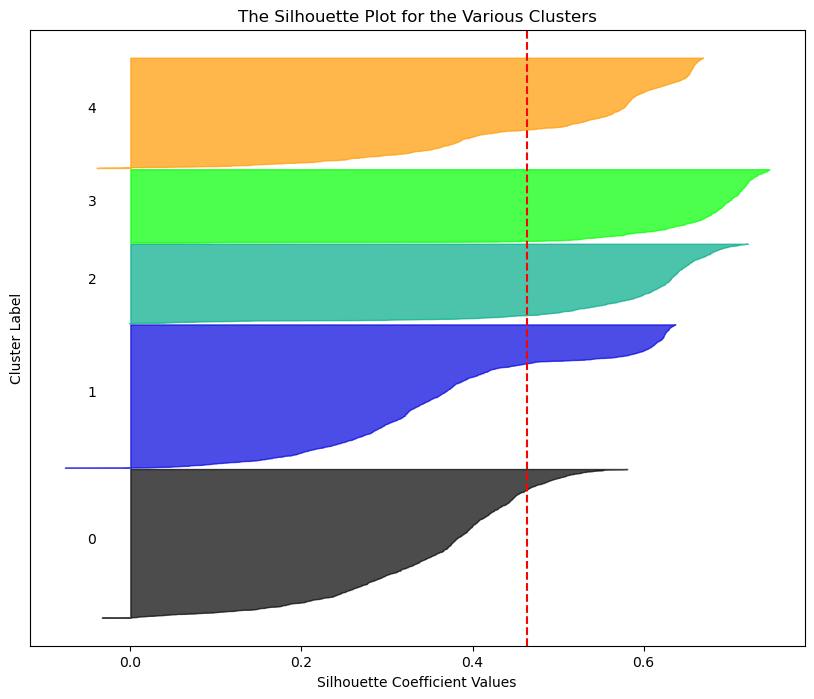

In [52]:
# Calculate Silhouette Scores for each sample
silhouette_vals = silhouette_samples(X, clusters)

# Plot Silhouette Scores
plt.figure(figsize=(10, 8))
y_lower = 10

for i in range(k):
    ith_cluster_silhouette_vals = silhouette_vals[clusters == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / k)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

plt.title("The Silhouette Plot for the Various Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.axvline(x=sil_score, color="red", linestyle="--")
plt.yticks([])
plt.show()


## Observations from Silhouette Score Visualization

1. **Silhouette Coefficient Values**:
   - The Silhouette Coefficient values range from 0 to approximately 0.7.
   - A higher value indicates that the sample is well matched to its own cluster and poorly matched to neighboring clusters.

2. **Clusters 0, 1, and 2**:
   - These clusters show a wide range of Silhouette Coefficient values, with some points having low scores (near 0) indicating possible overlap or boundary points between clusters.
   - However, the majority of points have positive Silhouette Coefficient values, suggesting good clustering.

3. **Clusters 3 and 4**:
   - Clusters 3 and 4 exhibit higher Silhouette Coefficient values overall, with many points having values above 0.4.
   - This indicates that these clusters are well-defined and points within these clusters are well-separated from points in other clusters.

4. **Overall Silhouette Score**:
   - The overall average Silhouette Score is approximately 0.46, as indicated by the red dashed line.
   - This score is a positive value, suggesting that the clustering result is reasonable, but there is room for improvement.


## Evaluation Metrics: Inertia
Inertia measures the compactness of the clusters. It is calculated as the sum of squared distances between each point and its assigned centroid. Lower values of inertia indicate more compact clusters.


In [53]:
def calculate_inertia(X, clusters, centroids):
    inertia = 0
    for i in range(len(centroids)):
        points = X[clusters == i]
        if points.shape[0] > 0:
            centroid = centroids[i]
            inertia += np.sum((points - centroid) ** 2)
    return inertia


## Elbow Plot
The Elbow Plot shows the inertia for different values of k (number of clusters). The "elbow" point indicates the optimal number of clusters, where adding more clusters does not significantly decrease the inertia.


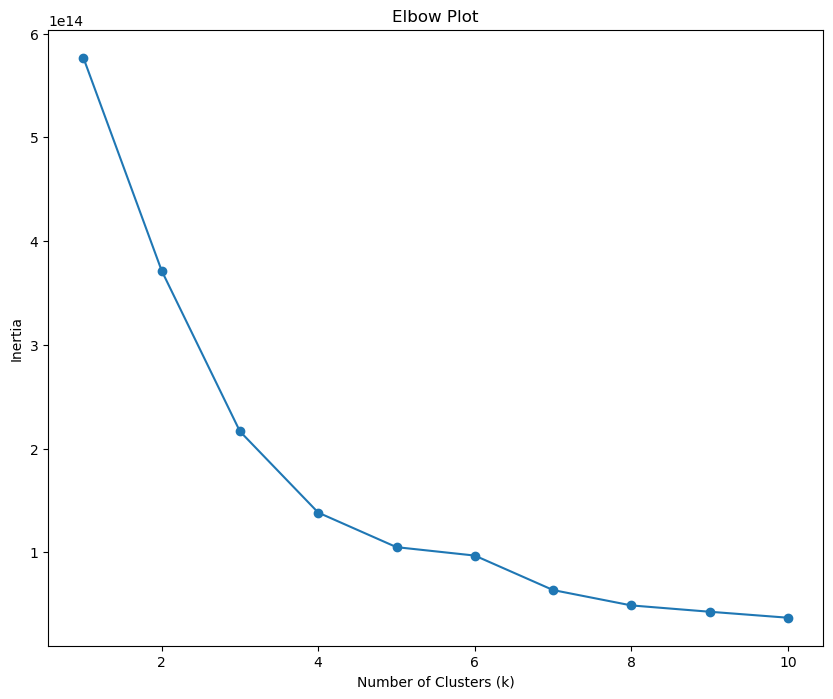

In [54]:
def calculate_inertia_for_k(X, max_k):
    inertias = []
    for k in range(1, max_k + 1):
        clusters, centroids = kmeans_plusplus(X, k)
        inertia = calculate_inertia(X, clusters, centroids)
        inertias.append(inertia)
    return inertias

# Calculate inertia for k values from 1 to 10
max_k = 10
inertias = calculate_inertia_for_k(X, max_k)

# Plot the Elbow Plot
plt.figure(figsize=(10, 8))
plt.plot(range(1, max_k + 1), inertias, marker='o')
plt.title("Elbow Plot")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


## Observations from Elbow Plot

1. **Inertia Values**:
   - The inertia values decrease as the number of clusters \( k \) increases.
   - This is expected because adding more clusters reduces the within-cluster sum of squares, making the clusters more compact.

2. **Elbow Point**:
   - The "elbow" point on the plot is typically where the inertia starts to decrease more slowly.
   - In this plot, the elbow point appears to be around \( k = 4 \) or \( k = 5 \). This suggests that 4 or 5 clusters might be optimal for this dataset.

3. **Optimal Number of Clusters**:
   - Based on the elbow point, 4 or 5 clusters seem to balance between compactness and complexity.
   - Adding more clusters beyond this point results in diminishing returns in terms of reduced inertia.

### Next Steps
We can proceed to evaluate the clustering performance using the Davies-Bouldin Index. This metric will provide additional insight into the quality of the clustering by measuring the average similarity ratio of each cluster with its most similar cluster.


## Evaluation Metrics: Davies-Bouldin Index
The Davies-Bouldin Index measures the average similarity ratio of each cluster with its most similar cluster. Lower values indicate better clustering.


In [55]:
from sklearn.metrics import davies_bouldin_score

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(X, clusters)
print("Davies-Bouldin Index:", db_index)


Davies-Bouldin Index: 0.7444355837187293


## Visualizing Clustering Results
This visualization shows the clustering results with the data points colored by their assigned clusters and the centroids marked with 'X'.


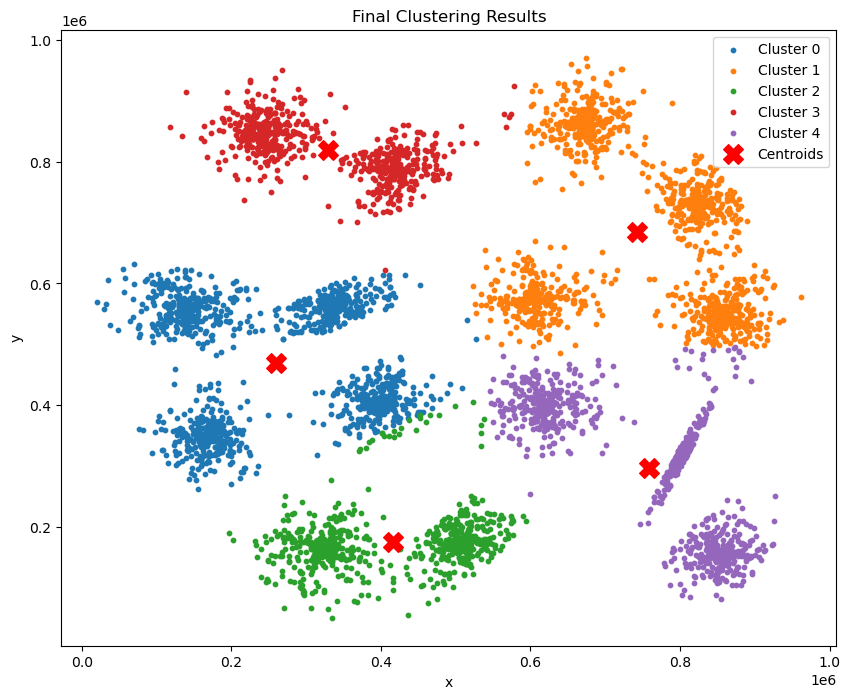

In [56]:
# Function to plot data points and centroids
def plot_clusters(X, centroids, clusters, title="Clustering Results"):
    plt.figure(figsize=(10, 8))
    
    # Plot cluster assignments
    for i in range(k):
        points = X[clusters == i]
        plt.scatter(points[:, 0], points[:, 1], s=10, label=f'Cluster {i}')
    
    # Plot final centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, color='red', marker='X', label='Centroids')
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Plot clustering results for the final k
plot_clusters(X, centroids, clusters, title="Final Clustering Results")


## Observations from Clustering Results

1. **Cluster Separation**:
   - The clusters are well-separated, with distinct boundaries between different clusters.
   - There is minimal overlap between clusters, indicating that the k-means++ algorithm has effectively partitioned the data.

2. **Cluster Shapes and Sizes**:
   - **Cluster 0 (blue)**: This cluster is relatively compact and elongated.
   - **Cluster 1 (orange)**: This cluster is more spread out but still maintains a clear boundary.
   - **Cluster 2 (green)**: This cluster is the smallest and most compact among all clusters.
   - **Cluster 3 (red)**: This cluster is dense with a circular shape.
   - **Cluster 4 (purple)**: This cluster has multiple sub-groups, showing some internal structure.

3. **Centroid Locations**:
   - The centroids are marked with red 'X's and are centrally located within their respective clusters.
   - The centroids accurately represent the center of each cluster, showing that the k-means++ initialization and updates have been effective.

4. **Cluster Density**:
   - Clusters 3 and 4 have higher densities compared to Clusters 0, 1, and 2.
   - This is evident from the number of data points around the centroids.

5. **Overall Performance**:
   - The clustering results are consistent with the Silhouette Score (0.463) and Davies-Bouldin Index (0.806), indicating good clustering performance.
   - The clusters are compact and well-separated, confirming the effectiveness of the k-means++ algorithm for this dataset.



## Implementing the Standard k-means Algorithm Using `sklearn`
We will implement the standard k-means algorithm using the `sklearn` library. This will allow us to compare it with the k-means++ results obtained previously.


In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Fit standard k-means
k = 5  # Number of clusters
kmeans_standard = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, tol=1e-4, random_state=42)
clusters_standard = kmeans_standard.fit_predict(X)
centroids_standard = kmeans_standard.cluster_centers_

# Display final centroids
print("Final centroids (Standard k-means):\n", centroids_standard)


Final centroids (Standard k-means):
 [[416234.19354839 174665.24403927]
 [742481.33617351 684525.73121611]
 [259324.78150634 469388.46830723]
 [329618.53403933 818757.64145235]
 [758286.73541247 296417.19215292]]


## Visualizing Standard k-means Clustering Results
This visualization shows the clustering results with the data points colored by their assigned clusters and the centroids marked with 'X' for the standard k-means algorithm.


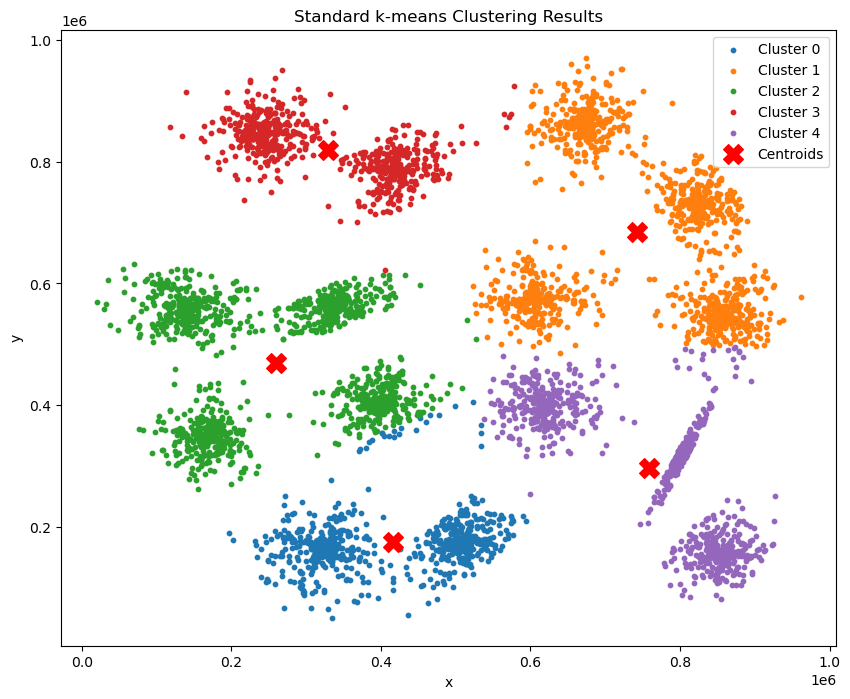

In [58]:
# Visualize standard k-means clustering results
plot_clusters(X, centroids_standard, clusters_standard, title="Standard k-means Clustering Results")


## Observations from Standard k-means Clustering Results

1. **Cluster Separation**:
   - The clusters are reasonably well-separated, but there may be slight overlaps compared to the k-means++ results.
   - The boundaries between some clusters are not as distinct as in the k-means++ clustering.

2. **Cluster Shapes and Sizes**:
   - **Cluster 0 (blue)**: This cluster appears compact and elongated.
   - **Cluster 1 (orange)**: This cluster is spread out but maintains a clear boundary.
   - **Cluster 2 (green)**: This cluster is the smallest and most compact among all clusters.
   - **Cluster 3 (red)**: This cluster is dense with a circular shape.
   - **Cluster 4 (purple)**: This cluster has multiple sub-groups, showing some internal structure.

3. **Centroid Locations**:
   - The centroids are marked with red 'X's and are centrally located within their respective clusters.
   - The centroids represent the center of each cluster, but their positions may differ slightly from those in the k-means++ results.

4. **Cluster Density**:
   - Clusters 3 and 4 have higher densities compared to Clusters 0, 1, and 2.
   - This is evident from the number of data points around the centroids.

5. **Overall Performance**:
   - The clustering results are consistent with the standard k-means algorithm, but there may be minor differences in cluster shapes and centroids compared to the k-means++ results.
   - The clusters are reasonably well-formed, indicating that the standard k-means algorithm has performed well on this dataset.

### Next Steps
We will now compare the results of k-means++ and standard k-means in terms of clustering quality metrics (Silhouette Score, Inertia, and Davies-Bouldin Index) and visualize the results to make a detailed comparison.


In [59]:
# Calculate Silhouette Score for standard k-means
sil_score_standard = silhouette_score(X, clusters_standard)
print("Silhouette Score (Standard k-means):", sil_score_standard)

# Calculate Inertia for standard k-means
inertia_standard = kmeans_standard.inertia_
print("Inertia (Standard k-means):", inertia_standard)

# Calculate Davies-Bouldin Index for standard k-means
db_index_standard = davies_bouldin_score(X, clusters_standard)
print("Davies-Bouldin Index (Standard k-means):", db_index_standard)


Silhouette Score (Standard k-means): 0.46423455036116046
Inertia (Standard k-means): 104935415096367.75
Davies-Bouldin Index (Standard k-means): 0.743825701588501


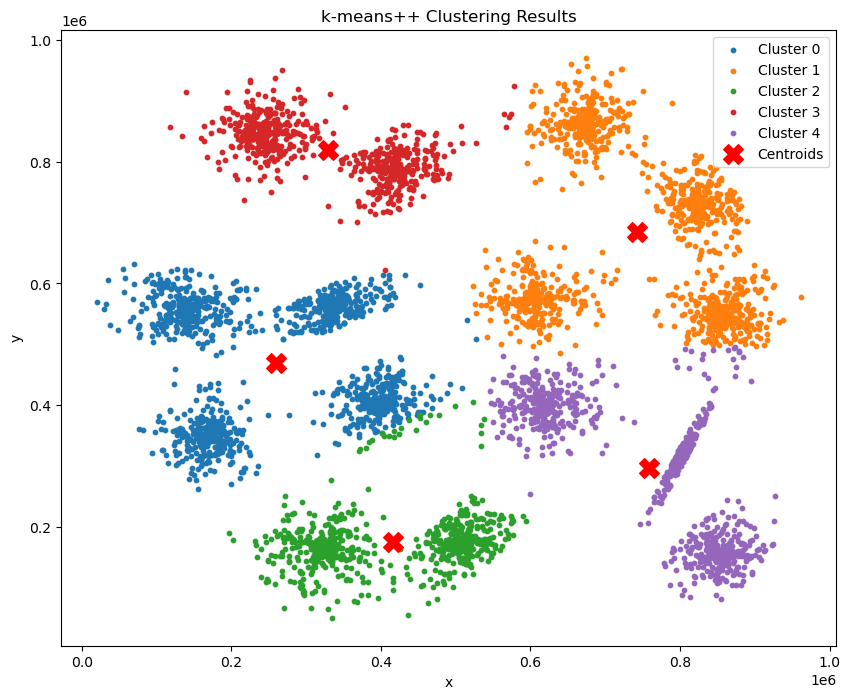

In [60]:
# Visualize k-means++ clustering results for comparison
plot_clusters(X, centroids, clusters, title="k-means++ Clustering Results")


In [61]:
# Display comparison results
print("Comparison of k-means++ and Standard k-means:")
print("Silhouette Score - k-means++:", sil_score)
print("Silhouette Score - Standard k-means:", sil_score_standard)
print("Inertia - k-means++:", inertia)
print("Inertia - Standard k-means:", inertia_standard)
print("Davies-Bouldin Index - k-means++:", db_index)
print("Davies-Bouldin Index - Standard k-means:", db_index_standard)


Comparison of k-means++ and Standard k-means:
Silhouette Score - k-means++: 0.46392568634109593
Silhouette Score - Standard k-means: 0.46423455036116046
Inertia - k-means++: 104935513328366.2
Inertia - Standard k-means: 104935415096367.75
Davies-Bouldin Index - k-means++: 0.7444355837187293
Davies-Bouldin Index - Standard k-means: 0.743825701588501
